In [1]:
import pandas as pd
import numpy as np
#import graphlab as tc
import turicreate as tc
from tqdm.notebook import tqdm
import turicreate.aggregate as agg
from sklearn.model_selection import train_test_split
from numpy.random import default_rng

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
import pickle
import matplotlib.pyplot as plt

In [2]:
mw = tc.load_sframe('../binarydata/funcs-encoded')
mw = mw.remove_column('fcount', inplace=True)

In [3]:
test_apns = np.load('../res/test-tc-1000.npy')

In [4]:
net_file = '../res/9003-tc-jaccard-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)

In [5]:
gamma = 0.6666666666666666
ref, mer = nets[gamma]

In [6]:
ref

{0: [0, 19],
 16384: [595, 0],
 24576: [0, 116],
 4096: [23, 1],
 12288: [0, 8],
 4097: [167, 0],
 12290: [0, 2],
 2: [5, 4],
 16386: [0, 50],
 4099: [596, 100],
 22529: [0, 7],
 6146: [62, 0],
 3: [617, 1438],
 20483: [40, 2],
 18435: [5, 0],
 10244: [6, 0],
 20485: [180, 265],
 18437: [47, 0],
 12294: [24, 208],
 20486: [134, 34],
 22534: [5, 78],
 18439: [250, 0],
 4105: [22, 0],
 10248: [5, 0],
 26632: [0, 112],
 18442: [40, 0],
 11: [101, 0],
 8203: [5, 0],
 2061: [0, 6],
 10254: [168, 0],
 26638: [0, 4],
 4111: [0, 17],
 14352: [3, 25],
 10257: [3, 0],
 6161: [12, 0],
 18: [29, 0],
 4115: [0, 21],
 21: [4, 0],
 16406: [107, 0],
 10262: [2, 0],
 2070: [0, 35],
 18454: [33, 0],
 18455: [3, 0],
 2073: [0, 8],
 26649: [0, 59],
 2074: [86, 18],
 10266: [41, 9],
 28: [28, 0],
 6172: [2, 23],
 26654: [0, 99],
 14367: [8, 7],
 4128: [0, 23],
 26656: [4, 9],
 20513: [11, 1],
 8227: [8, 0],
 35: [0, 53],
 26660: [0, 37],
 2085: [0, 38],
 10277: [0, 20],
 18469: [5, 5],
 22565: [0, 2],
 123

In [30]:
## recommender for all exclude test from similar items?

In [12]:
from streamed import tc_based_nn

def s_conver_to_probs(v):
    return 1.0 - v[1]/(v[0]+v[1])

def eval_net(net, test_apns, data):
    nns = tc_based_nn(net, list(test_apns), data)
    return [s_conver_to_probs(net[row['nn']]) for row in nns.sort('apk')]

In [81]:
nns = tc_based_nn(ref, list(test_apns), mw)

nns.head()

apk,nn
26561,3
16257,20486
12088,3
2464,9218
26001,3
19279,11
18741,18454
18939,2074
21368,3
11452,20486


In [105]:
## full prediction

In [384]:
res = dict()
res_mer = dict()

#sorting to keep the results consistent (probs matching true values)
test_apns.sort()
true_values = [not labels.loc[a]['malware_label'] for a in test_apns]


for gamma, [ref, mer] in tqdm(nets.items()):
    res[gamma] = [eval_net(net=ref, test_apns=test_apns, data=mw), true_values]
    res_mer[gamma] = [eval_net(net=mer, test_apns=test_apns, data=mw), true_values]
    

  0%|          | 0/19 [00:00<?, ?it/s]

In [385]:
with open('../res/tc-new-res.pickle', 'wb+') as f:
    pickle.dump(res, f)

with open('../res/tc-new-mer.pickle', 'wb+') as f:
    pickle.dump(res_mer, f)

In [163]:
gammas = [0.0, 0.5, 0.6111111111111112, 0.7777777777777778, 0.8888888888888888]

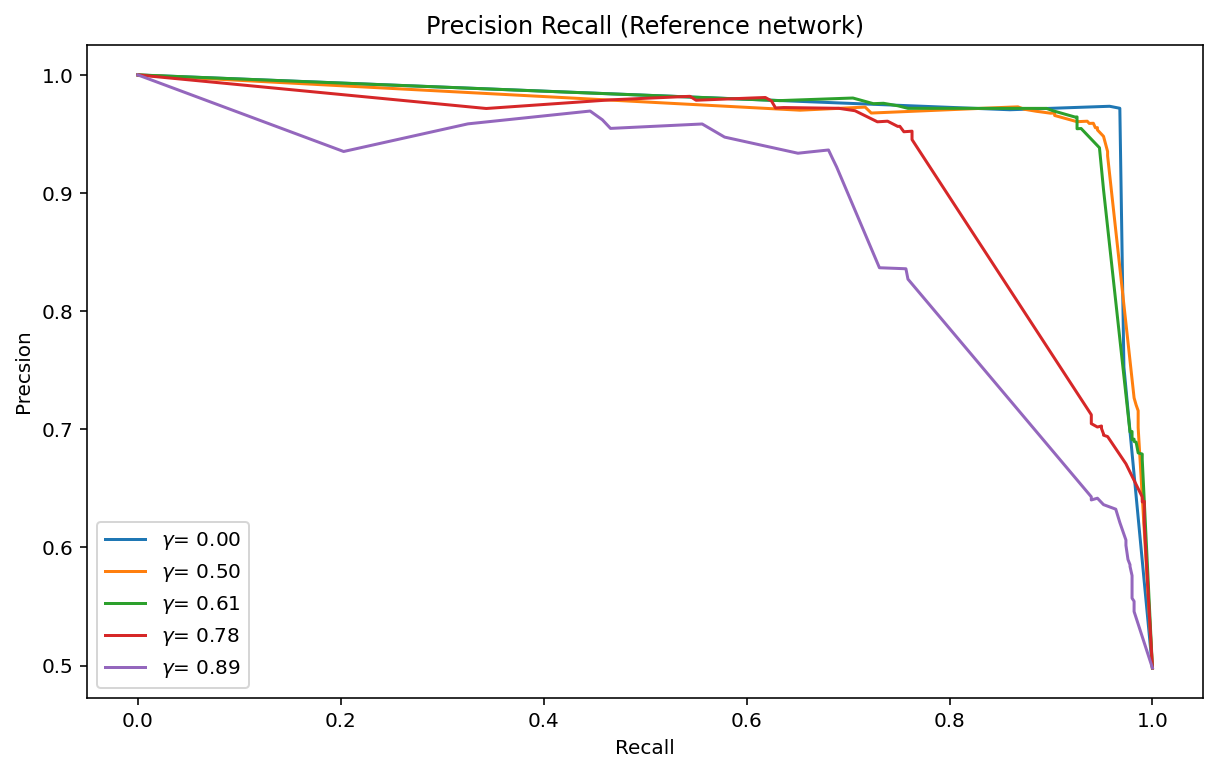

In [172]:
plt.figure(figsize=(10,6))
plt.title('Precision Recall (Reference network)')
plt.xlabel('Recall')
plt.ylabel('Precsion')
for gamma in gammas:
    probs, true_vals = res[gamma]
    [precisons, recalls, thresholds] = precision_recall_curve(true_vals, probs)
    plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f}")
plt.legend();

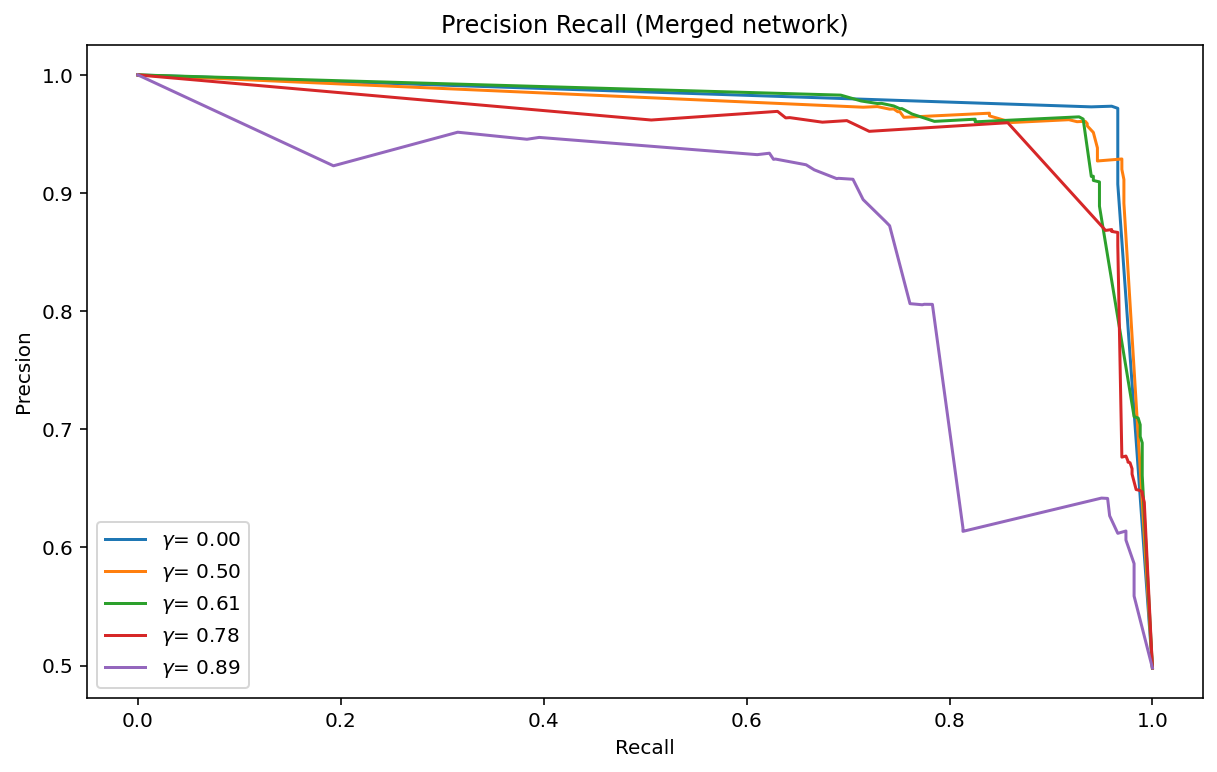

In [171]:
plt.figure(figsize=(10,6))
plt.title('Precision Recall (Merged network)')
plt.xlabel('Recall')
plt.ylabel('Precsion')
for gamma in gammas:
    probs, true_vals = res_mer[gamma]
    [precisons, recalls, thresholds] = precision_recall_curve(true_vals, probs)
    plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f}")
plt.legend();
# AuC

In [183]:
# compression
d_size = sum(map(sum, mer.values()))

compr = dict()
for gamma, [ref, mer] in nets.items():
    compr[gamma] = [len(ref)/d_size, len(mer) /d_size]

df = pd.DataFrame.from_dict(compr, orient='index', columns=['ref', 'mer'])

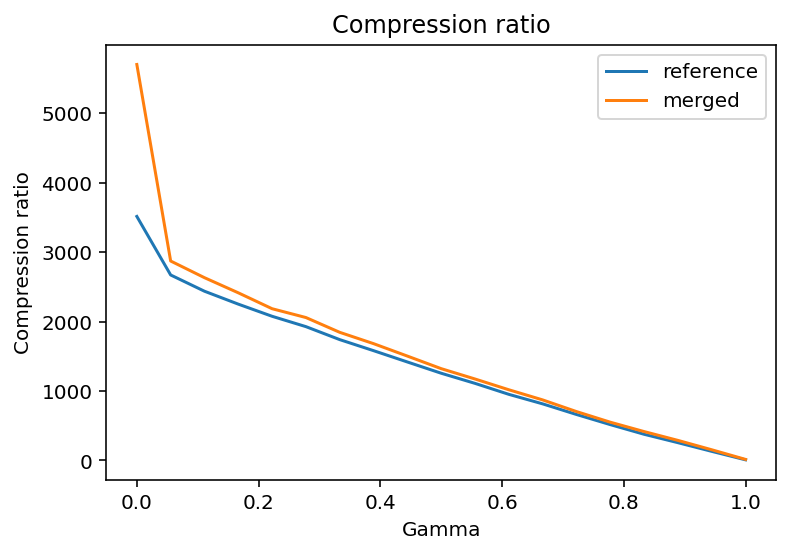

In [245]:
plt.title("Compression ratio ")
plt.plot(df.ref*d_size, label='reference')
plt.plot(df.mer*d_size, label='merged')
plt.xlabel('Gamma')
plt.ylabel('Compression ratio')
plt.legend();

In [430]:
from scipy.stats import linregress

In [439]:
comp_mer = {gamma: len(voting) for gamma, [merged, voting] in nets.items()}

In [442]:

res = linregress(list(comp_mer.keys())[1:], list(comp_mer.values())[1:])
print(res)


LinregressResult(slope=-2972.6377708978325, intercept=2884.836601307189, rvalue=-0.9972534373717314, pvalue=1.614141302623645e-19, stderr=55.19348288747532, intercept_stderr=33.19077036024268)


In [449]:
np.array(list(comp_mer.keys()))

array([0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
       0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ,
       0.55555556, 0.61111111, 0.66666667, 0.72222222, 0.77777778,
       0.83333333, 0.88888889, 0.94444444, 1.        ])

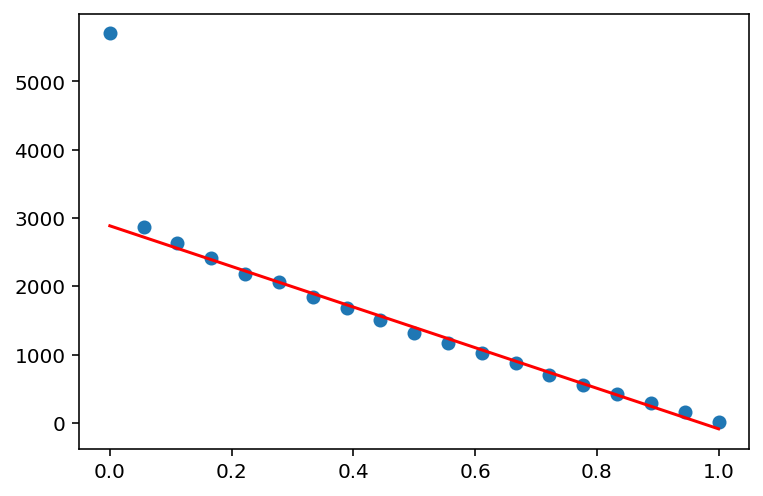

In [450]:
x = np.array(list(comp_mer.keys()))
y = list(comp_mer.values())

plt.plot(x, y, 'o')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')


## TODOs
1. AuC to actually compare the merged and reference network
1. slope of the compression curve
1. debug the netowrk creation strange results
1. streaming-based creation

### Streaming-based creation
1. partition data,
1. create network for the first partition
1. use their anchors to calculate (update) networks for other
- prediction?
1. merge (concatation)

In [320]:
## stream eval

In [25]:
with open('../res/9003-stream-nets.pickle', 'rb') as f:
    st_nets = pickle.load(f)

In [26]:
with open('../res/9003-new-stream-nets.pickle', 'rb') as f:
    stn_nets = pickle.load(f)

In [27]:
for gamma, [merged, voting] in stn_nets.items():
    print(gamma, sum(map(sum, voting.values())))

0.0 9003
0.05555555555555555 9003
0.1111111111111111 9003
0.16666666666666666 9003
0.2222222222222222 9003
0.2777777777777778 9003
0.3333333333333333 9003
0.3888888888888889 9003
0.4444444444444444 9003
0.5 9003
0.5555555555555556 9003
0.6111111111111112 9003
0.6666666666666666 9003
0.7222222222222222 9003
0.7777777777777778 9003
0.8333333333333334 9003
0.8888888888888888 9003
0.9444444444444444 9003
1.0 8997


In [326]:
gamma = 0.6666666666666666

In [327]:
[merged, voting]  = st_nets[gamma]

In [31]:
test_apns.sort()
labels = pd.read_csv('../data/labels_encoded.csv', index_col=0)
true_values = [not labels.loc[a]['malware_label'] for a in test_apns]

In [39]:
probs = dict()
for gamma, [merged, voting] in tqdm(stn_nets.items()):
    probs[gamma] = eval_net(net=voting, test_apns=test_apns, data=mw)

  0%|          | 0/19 [00:00<?, ?it/s]

In [40]:
with open('../res/tc-stream-new-probs.pickle', 'wb+') as f:
    pickle.dump(probs, f)


In [41]:
gammas = [0.0, 0.5, 0.6111111111111112, 0.7777777777777778, 0.8888888888888888]
plt.figure(figsize=(10,8))
for gamma in gammas:
    [precisons, recalls, thresholds] = precision_recall_curve(true_vals, probs[gamma])
    roc_auc = metrics.roc_auc_score(true_vals, probs[gamma])
    plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f} (auc={roc_auc:.2f})")
plt.legend();

NameError: name 'true_vals' is not defined

<Figure size 720x576 with 0 Axes>

In [8]:
# auc
from sklearn import metrics

In [370]:
gamma = 0.8888888888888888
metrics.roc_auc_score(true_vals, probs[gamma]) 


0.9034244547912766

In [359]:
size = sum(map(sum, st_nets[0.0][1].values()))
comp = {gamma: len(voting) for gamma, [merged, voting] in st_nets.items()}

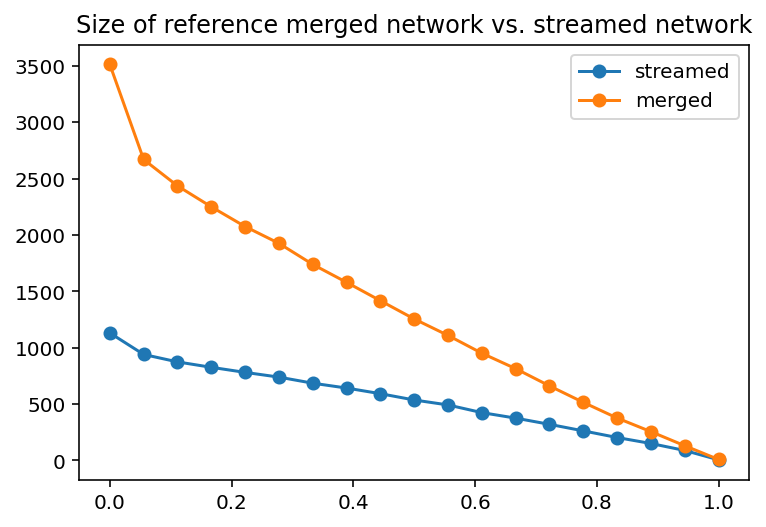

In [361]:
plt.title('Size of reference merged network vs. streamed network')
plt.plot(list(comp.keys()), list(comp.values()),'-o', label='streamed')
plt.plot(df.ref*d_size, '-o', label='merged')
plt.legend();

In [356]:
single_nets = dict()
for gamma in st_nets.keys():
    with open(f"../res/{gamma}-tc-singlevoting.pickle", 'rb') as f:
        nw = pickle.load(f)
        single_nets[gamma] = nw[gamma]

In [358]:
single_sizes = {g:len(a[0]) for g, a in single_nets.items()}

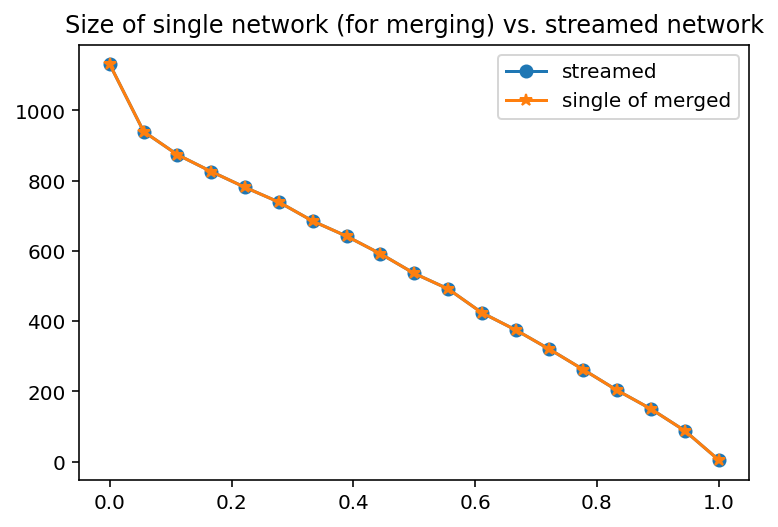

In [363]:
plt.title('Size of single network (for merging) vs. streamed network')
plt.plot(list(comp.keys()), list(comp.values()),'-o', label='streamed')
plt.plot(list(single_sizes.keys()), list(single_sizes.values()), '-*', label='single of merged')
plt.legend();

In [378]:
# Precision comprarision between streamed and merged

In [388]:
with open('../res/tc-new-mer.pickle', 'rb') as f:
    res_mer = pickle.load(f)

with open('../res/tc-stream-probs.pickle', 'rb') as f:
    res_str = pickle.load(f)

In [405]:
gammas = list(res_mer.keys())[:-1]
to_plot=dict()

for gamma in gammas:
    probs, true_vals = res_mer[gamma]
    [p1, r1, thresholds] = precision_recall_curve(true_vals, res_str[gamma])
    roc_auc1 = metrics.roc_auc_score(true_vals, probs) 
    
    [p2, r2, thresholds] = precision_recall_curve(true_vals, probs)
    roc_auc2 = metrics.roc_auc_score(true_vals, res_str[gamma])

    to_plot[gamma] = [p1, r1, roc_auc1, p2, r2, roc_auc2]

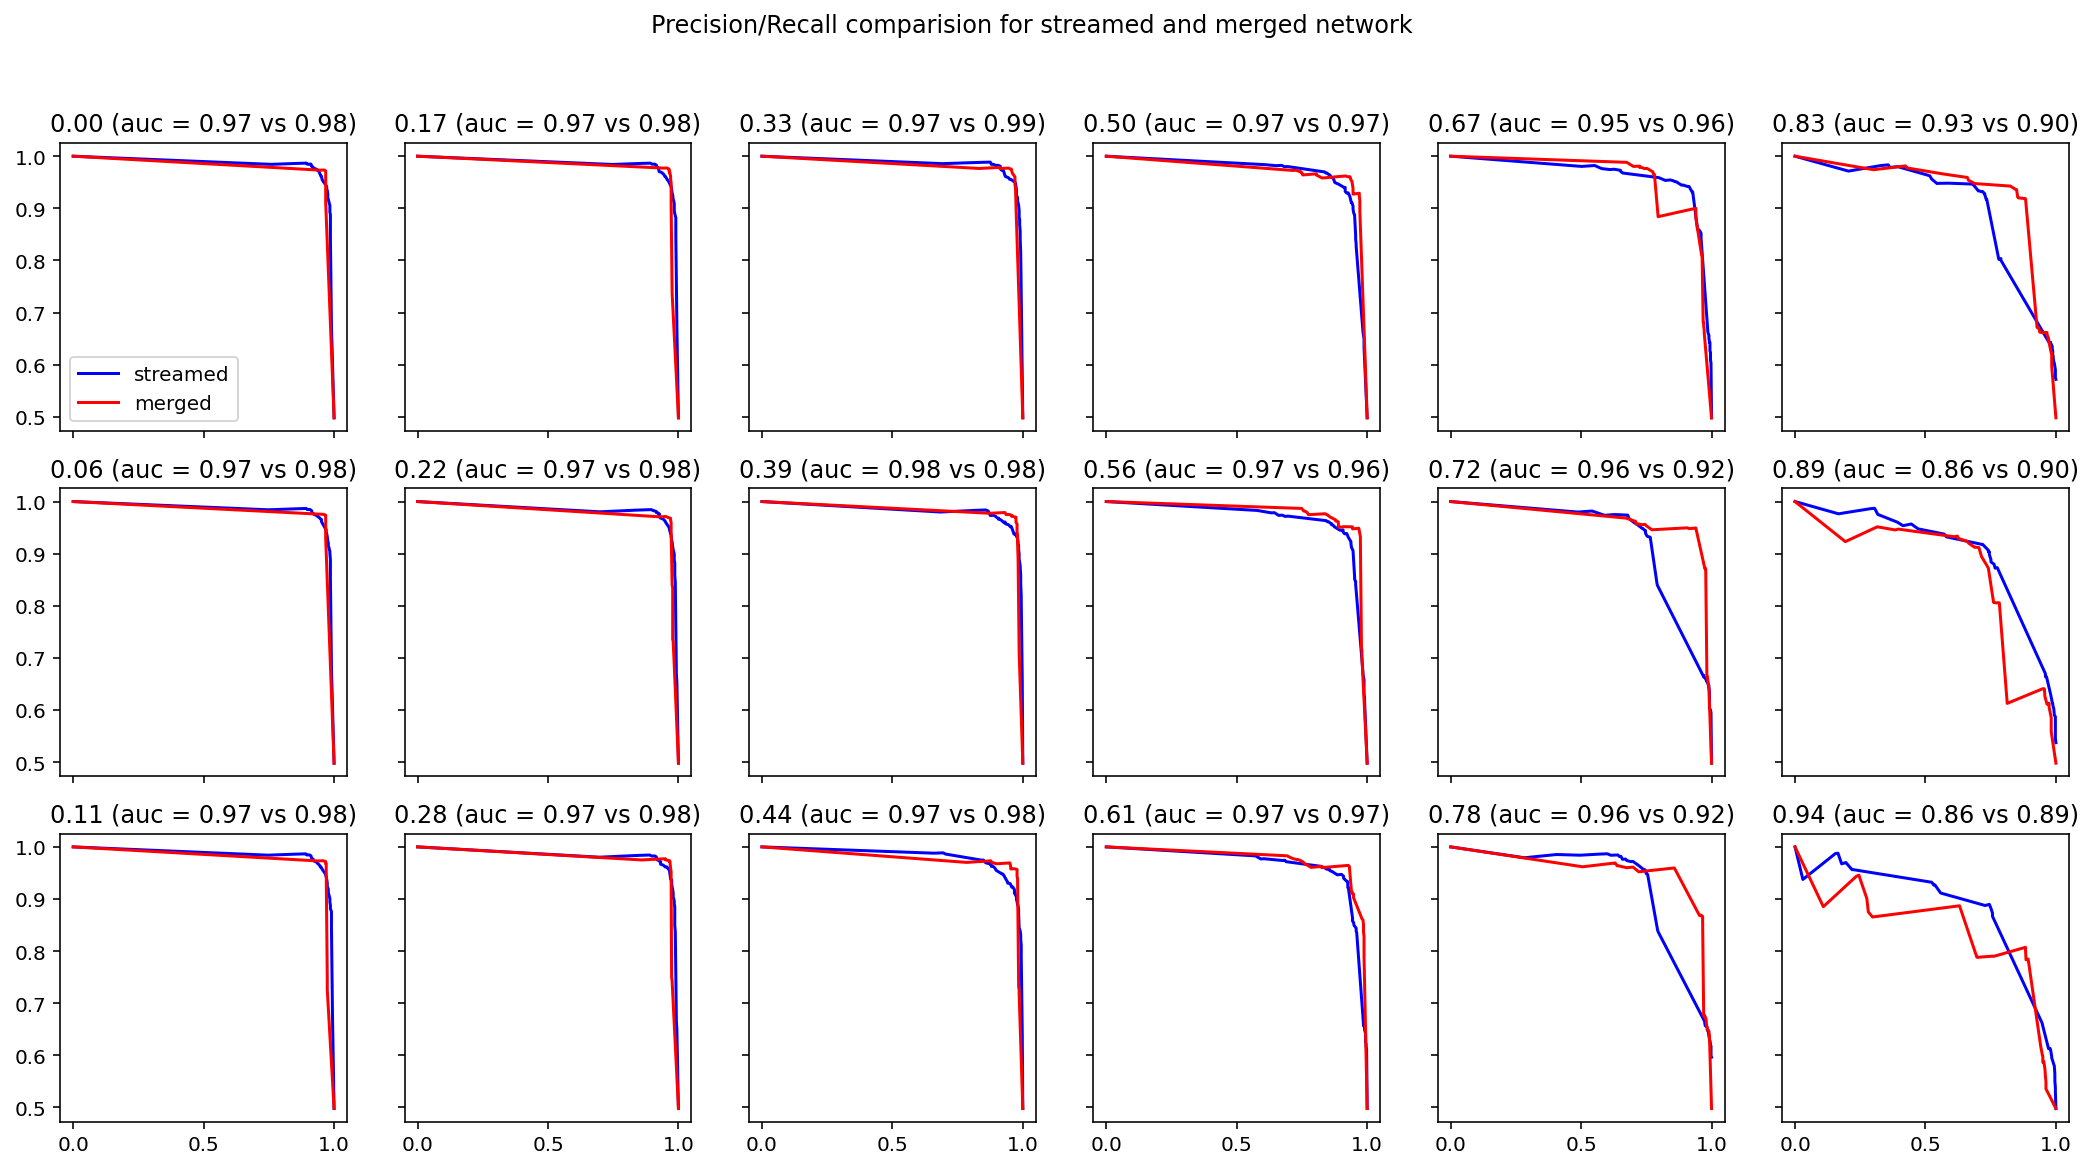

In [429]:
rows = 3
cols = 6

fig, axs = plt.subplots(rows, cols, figsize=(18, 9), sharex=True, sharey=True)
fig.suptitle('Precision/Recall comparision for streamed and merged network')
for i, gamma in enumerate(to_plot.keys()):
    [p1, r1, roc_auc1, p2, r2, roc_auc2] = to_plot[gamma]
    axs[i%rows, i//rows].plot(r1, p1, c='b', label='streamed')
    axs[i%rows, i//rows].plot(r2, p2, c='r', label='merged')
    axs[i%rows, i//rows].set_title(f"{gamma:.2f} (auc = {roc_auc1:.2f} vs {roc_auc2:.2f})")

axs[0,0].legend();

In [3]:
net_file = '../res/9003-tc-jaccard-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)

In [21]:
with open('../res/new-9003-tc-jaccard-votingnets.pickle', 'rb') as f:
    new_nets = pickle.load(f)

with open('../res/3pass-9003-tc-jaccard-votingnets.pickle', 'rb') as f:
    new3_nets = pickle.load(f)



In [22]:
rr = dict()
for gamma, [mer, ref] in nets.items():
    new_mer, new_ref = new_nets[gamma]
    new3_mer, new3_ref = new3_nets[gamma]
    rr[gamma] = [len(mer), len(new_mer), len(new3_mer),len(ref), len(new_ref),len(new3_ref) ]
    print("%.2f" % gamma, rr[gamma])

0.00 [3513, 3513, 3513, 5701, 3513, 3513]
0.06 [2670, 2670, 2670, 2871, 2672, 2672]
0.11 [2436, 2436, 2436, 2631, 2448, 2448]
0.17 [2250, 2250, 2250, 2413, 2262, 2262]
0.22 [2075, 2075, 2075, 2184, 2084, 2084]
0.28 [1926, 1926, 1926, 2057, 1937, 1937]
0.33 [1739, 1739, 1739, 1844, 1762, 1762]
0.39 [1580, 1580, 1580, 1681, 1601, 1601]
0.44 [1417, 1417, 1417, 1502, 1441, 1441]
0.50 [1255, 1255, 1255, 1321, 1269, 1269]
0.56 [1109, 1109, 1109, 1172, 1134, 1134]
0.61 [951, 951, 951, 1017, 980, 980]
0.67 [814, 814, 814, 871, 835, 835]
0.72 [661, 661, 661, 703, 686, 686]
0.78 [515, 515, 515, 550, 526, 526]
0.83 [376, 376, 376, 415, 403, 403]
0.89 [255, 255, 255, 288, 267, 267]
0.94 [130, 130, 130, 153, 137, 137]
1.00 [8, 8, 8, 14, 9, 9]


In [23]:
df = pd.DataFrame.from_dict(rr, orient='index', columns=['mer', 'new_mer','new3_mer', 'ref', 'new_ref', 'new3_ref'])

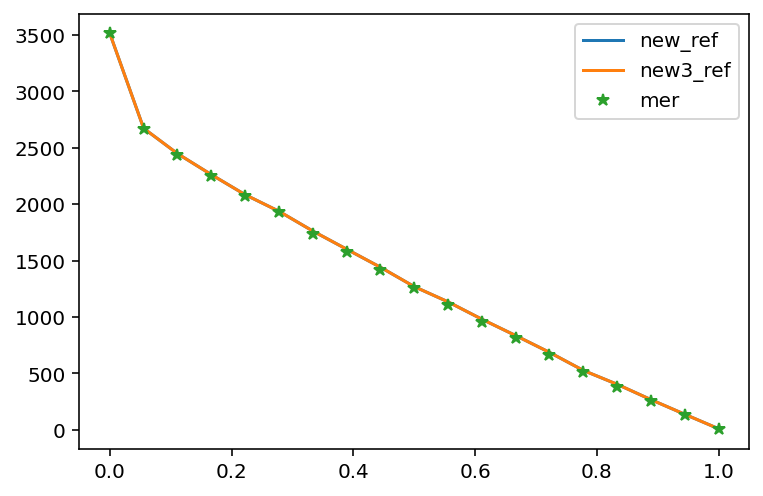

In [24]:
#plt.plot(df.ref, label='ref')
plt.plot(df.new_ref, label='new_ref')
plt.plot(df.new3_ref, label='new3_ref')
plt.plot(df.mer,'*', label='mer')
plt.legend()

# New results

In [3]:
! ls -altr ../res/probs* | tail

-rw-r--r--  1 jj  staff  180866 Nov 27 16:58 ../res/probs.pickle
-rw-r--r--  1 jj  staff  331583 Feb 18 11:52 ../res/probs-merged-th15_merged.pickle
-rw-r--r--  1 jj  staff  172388 Feb 18 12:42 ../res/probs-stream-th15.pickle
-rw-r--r--  1 jj  staff  172397 Feb 18 13:24 ../res/probs-ref-th15.pickle


In [3]:
with open('../res/probs-merged-th15_merged.pickle', 'rb') as f:
    merged_probs = pickle.load(f)
    
with open('../res/probs-stream-th15.pickle', 'rb') as f:
    stream_probs = pickle.load(f)
    
with open('../res/probs-ref-th15.pickle', 'rb') as f:
    ref_probs = pickle.load(f)
    


In [6]:
# new results
with open('../res/newres/probs_new_merged.pickle', 'rb') as f:
    merged_probs = pickle.load(f)
    
with open('../res/newres/probs-new-streamed.pickle', 'rb') as f:
    stream_probs = pickle.load(f)
    
with open('../res/newres/probs_new_ref.pickle', 'rb') as f:
    ref_probs = pickle.load(f)

In [7]:
gammas = list(ref_probs.keys())[:-1]
to_plot=dict()

for gamma in gammas:
    probs, true_vals = ref_probs[gamma]
    [p1, r1, thresholds] = precision_recall_curve(true_vals, probs)
    auc1 = auc(r1, p1)
    
    probs, true_vals = merged_probs[gamma]
    [p2, r2, thresholds] = precision_recall_curve(true_vals, probs)
    auc2 = auc(r2, p2)
    
    probs, true_vals = stream_probs[gamma]
    [p3, r3, thresholds] = precision_recall_curve(true_vals, probs)
    auc3 = auc(r3, p3)
    
    

    to_plot[gamma] = [p1, r1, auc1, p2, r2, auc2, p3, r3, auc3]

In [4]:
import matplotlib as mpl

mpl.use('svg')
new_rc_params = {
    "font.family": 'Times', #probably python doesn't know Times, but it will replace it with a different font anyway. The final decision is up to the latex document anyway
    "font.size": 14, #choosing the font size helps latex to place all the labels, ticks etc. in the right place
    "font.serif": [],
    "svg.fonttype": 'none',
    "lines.linewidth":2,
"lines.color":'k'} #to store text as text, not as path
mpl.rcParams.update(new_rc_params)

IndexError: index 6 is out of bounds for axis 1 with size 6

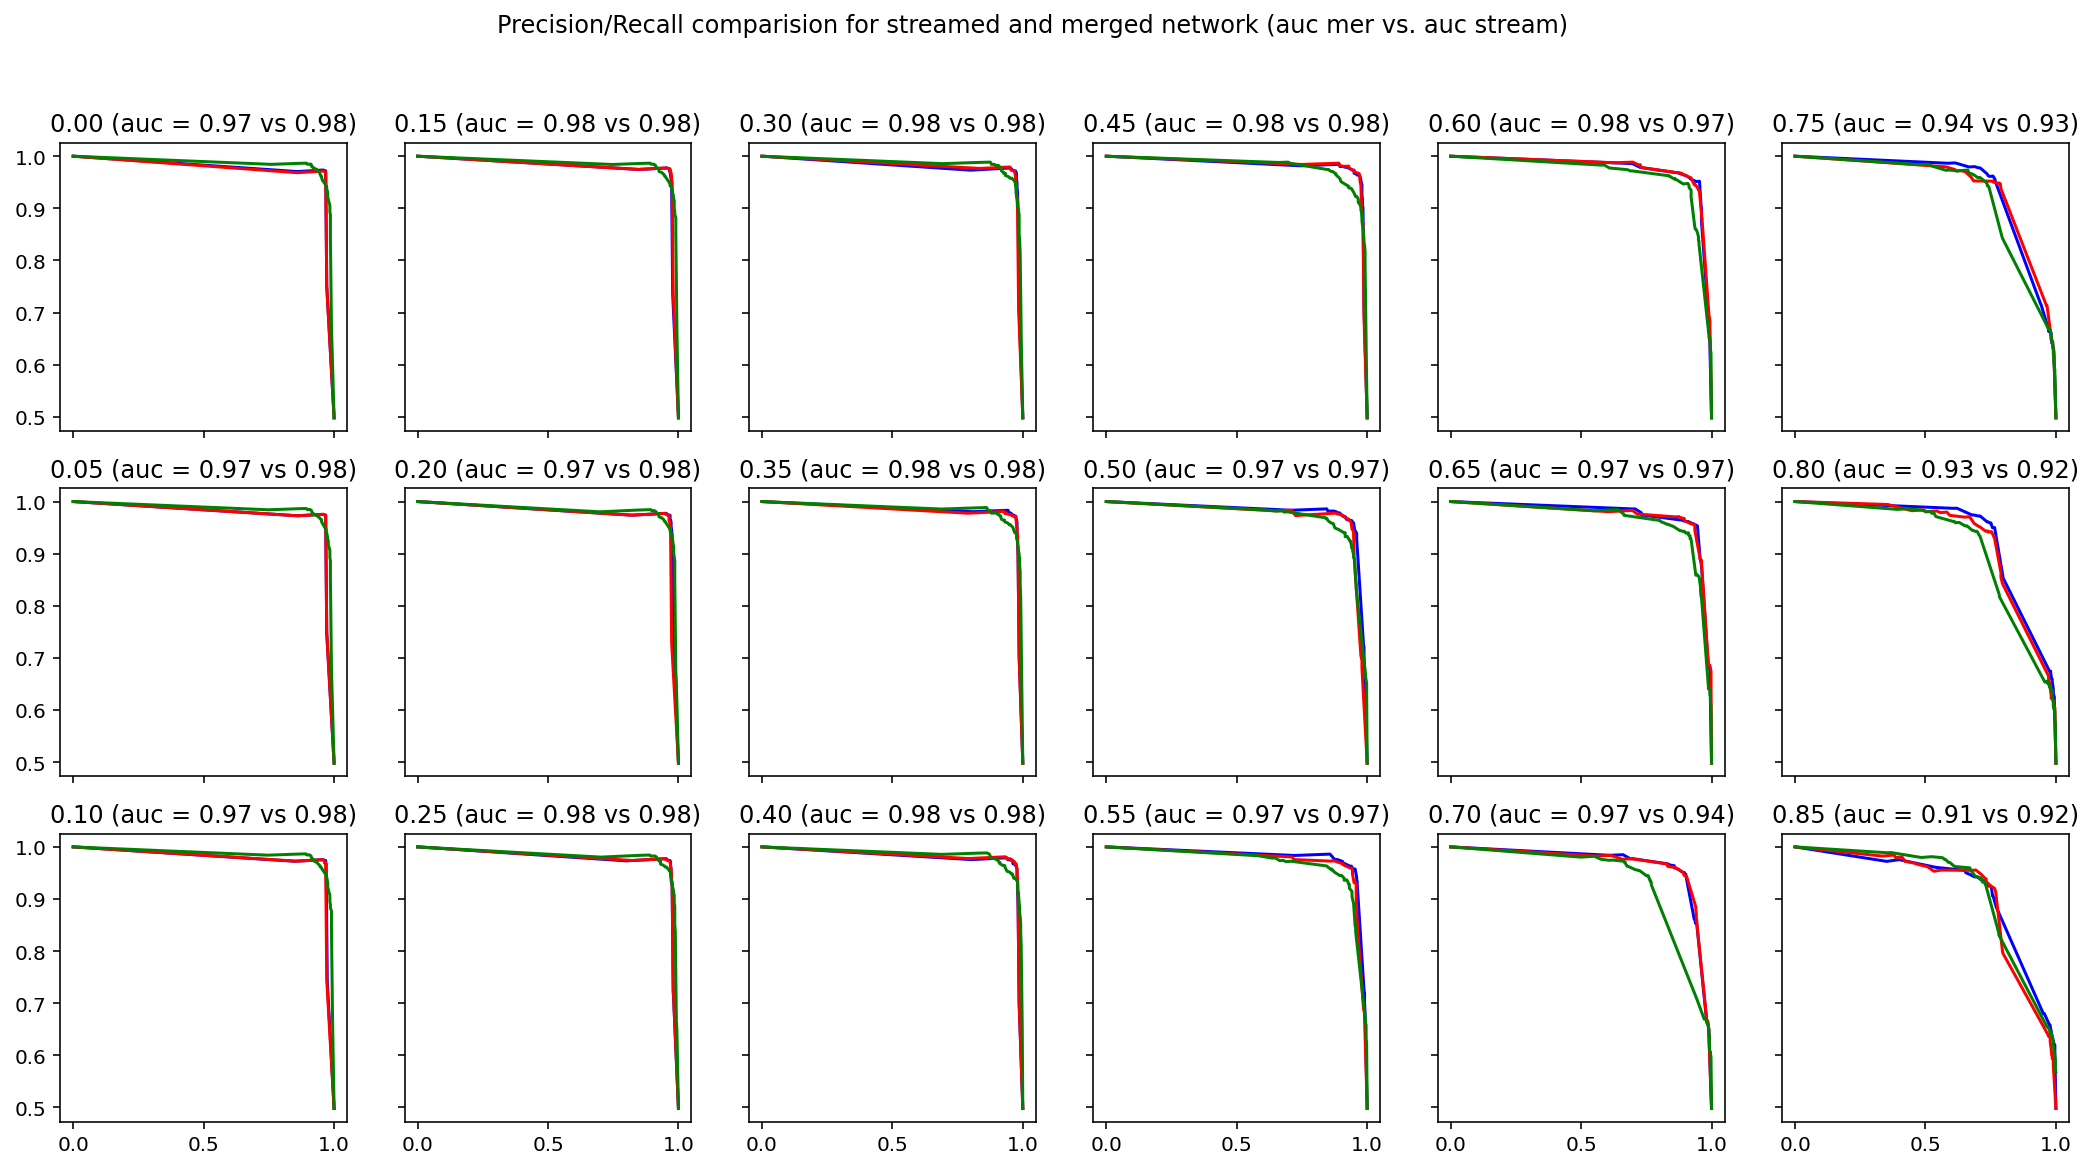

In [8]:
rows = 3
cols = 6

fig, axs = plt.subplots(rows, cols, figsize=(18, 9), sharex=True, sharey=True)
fig.suptitle('Precision/Recall comparision for streamed and merged network (auc mer vs. auc stream)')
for i, gamma in enumerate(to_plot.keys()):
    [p1, r1, auc1, p2, r2, auc2, p3, r3, auc3] = to_plot[gamma]
    axs[i%rows, i//rows].plot(r1, p1, c='b', label='reference')
    axs[i%rows, i//rows].plot(r2, p2, c='r', label='merged')
    axs[i%rows, i//rows].plot(r3, p3, c='g', label='streamed')
    axs[i%rows, i//rows].set_title(f"{gamma:.2f} (auc = {auc2:.2f} vs {auc3:.2f})")

axs[0,0].legend();

In [9]:
aucs = dict()
for gamma, [p1, r1, auc1, p2, r2, auc2, p3, r3, auc3]  in to_plot.items():
    aucs[gamma] = [auc1, auc2, auc3]

df = pd.DataFrame.from_dict(aucs, orient='index', columns=['auc_ref', 'auc_mer', 'auc_stream'])

In [10]:
df

,auc_ref,auc_mer,auc_stream
0.00,0.973198,0.972007,0.983472
0.05,0.974305,0.974305,0.983427
0.10,0.974628,0.974102,0.984404
0.15,0.976995,0.977731,0.984534
0.20,0.976920,0.974779,0.981025
0.25,0.976248,0.976830,0.981666
0.30,0.978113,0.979324,0.984361
0.35,0.982028,0.980187,0.984546
0.40,0.979196,0.980335,0.984902
0.45,0.982307,0.983266,0.980796


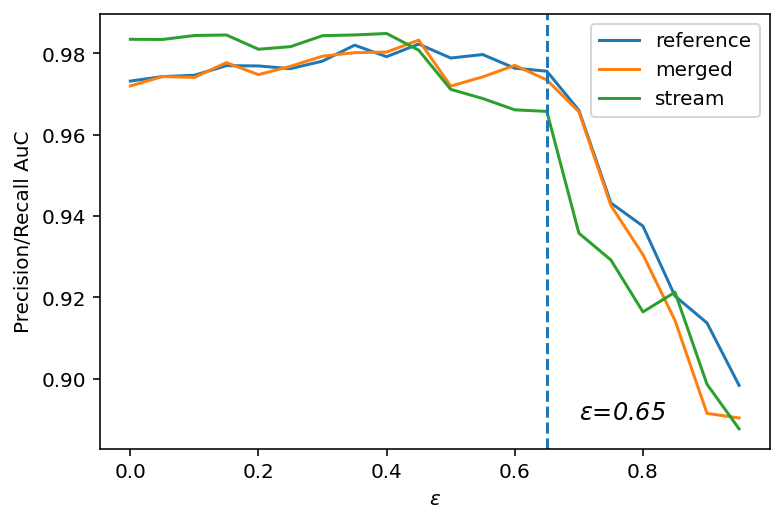

In [13]:
gamma = 0.65
#plt.title('Precision/Recall AuC')
plt.plot(df.auc_ref, label='reference')
plt.plot(df.auc_mer, label='merged')
plt.plot(df.auc_stream, label='stream')
plt.axvline(x=gamma, ls='--', label='')
plt.xlabel("$\epsilon$")
plt.legend()
plt.text(.7, .89, f"$\epsilon$={gamma:.2f}", style='italic', fontsize=12)
plt.ylabel('Precision/Recall AuC');


plt.savefig('../fig/prreauc.svg', format='svg', bbox_inches = 'tight', dpi=1000)

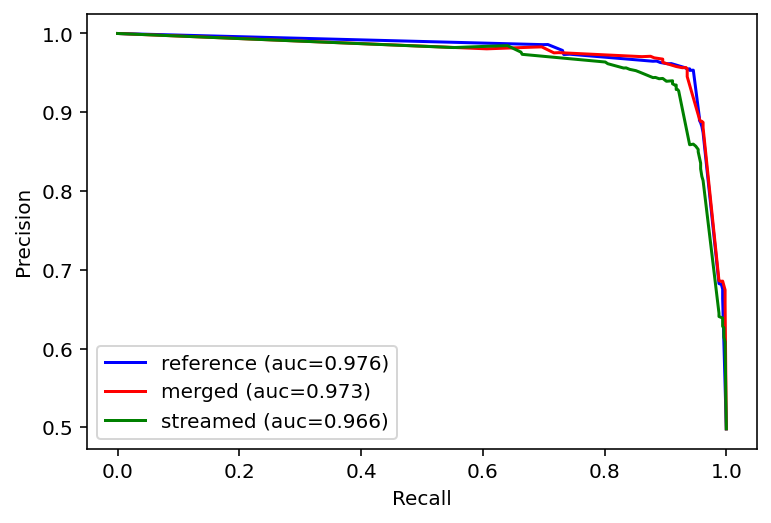

In [14]:
# probably the last good one:
gamma = 0.65
plt.plot(figsize=(12,8))
#plt.title(f"Precision/recall plot $\epsilon$={gamma:.2f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
[p1, r1, auc1, p2, r2, auc2, p3, r3, auc3] = to_plot[gamma]
plt.plot(r1, p1, c='b', label=f"reference (auc={auc1:.3f})")
plt.plot(r2, p2, c='r', label=f"merged (auc={auc2:.3f})")
plt.plot(r3, p3, c='g', label=f"streamed (auc={auc3:.3f})")
plt.legend(fancybox=True);
plt.savefig('../fig/prrec06.svg', format='svg', bbox_inches = 'tight', dpi=1000)

In [21]:
# compressions

In [78]:
#merged-th15_ref.pickle
#stream-th15_aggreg.pickle
with open('../res/merg_2.pickle', 'rb') as f:
    nets_merged = pickle.load(f)
    
with open('../res/merged-th15_ref.pickle', 'rb') as f:
    nets_reference = pickle.load(f)
    
with open('../res/stream_2.pickle', 'rb') as f:
    nets_streamed = pickle.load(f)

In [17]:
#merged-th15_ref.pickle
#stream-th15_aggreg.pickle
with open('../res/newres/new_merged_merged.pickle', 'rb') as f:
    nets_merged = pickle.load(f)
    
with open('../res/newres/new_merged_ref.pickle', 'rb') as f:
    nets_reference = pickle.load(f)
    
with open('../res/newres/new_streamed_vot.pickle', 'rb') as f:
    nets_streamed = pickle.load(f)

In [18]:
for n in [nets_merged, nets_reference, nets_streamed]:
    print(sum(map(sum, n[0.0].values())))

9003
9003
9003


In [19]:
size = sum(map(sum, nets_reference[0.0].values()))

comp_merged = {gamma: len(net) for gamma, net in nets_merged.items()}
comp_ref = {gamma: len(net) for gamma,net in nets_reference.items()}
comp_stream = {gamma: len(net) for gamma,net in nets_streamed.items()}

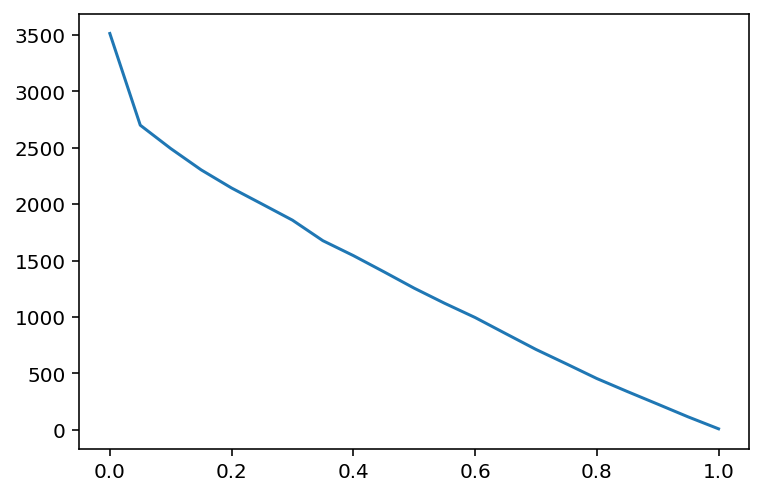

In [20]:
plt.plot(list(comp_merged.keys()), np.array(list(comp_merged.values())))

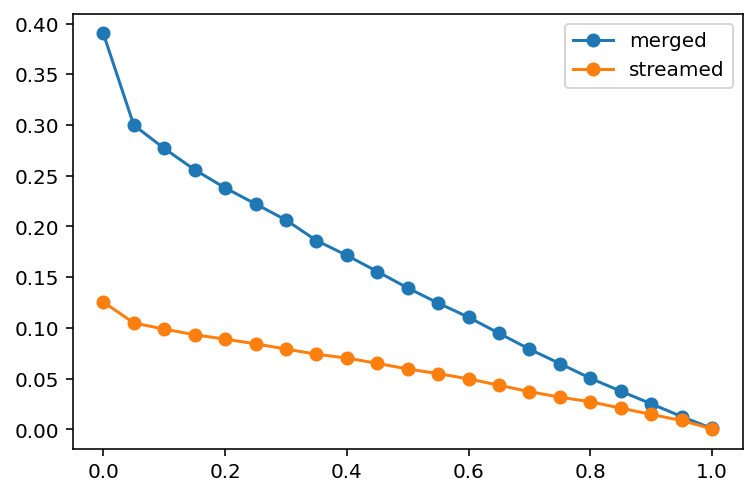

In [23]:
#plt.title('Compresion merged network vs. streamed network')
plt.plot(list(comp_merged.keys()), np.array(list(comp_merged.values()))/size,'-o', label='merged')
#plt.plot(list(comp_ref.keys()), np.array(list(comp_ref.values()))/size,'-o', label='reference')
plt.plot(list(comp_stream.keys()), np.array(list(comp_stream.values()))/size,'-o', label='streamed')

plt.legend();
plt.savefig('../fig/compres.svg', format='svg', bbox_inches = 'tight', dpi=1000)

In [84]:
size

9003

In [71]:
with open('../res/stream_2.pickle', 'rb') as f:
    nets_merged = pickle.load(f)

In [72]:
nets_merged[0.0]

{16393: [36, 1279],
 10246: [44, 0],
 14345: [346, 3],
 18442: [17, 0],
 4109: [9, 0],
 18448: [30, 0],
 12305: [0, 57],
 4115: [1, 4],
 16406: [21, 0],
 6166: [10, 0],
 26649: [0, 17],
 2077: [0, 8],
 2094: [0, 27],
 24626: [0, 5],
 2098: [23, 0],
 8244: [0, 29],
 18484: [55, 1],
 18490: [11, 1],
 14394: [0, 8],
 18494: [7, 1],
 22596: [0, 11],
 8272: [8, 0],
 16466: [0, 5],
 22611: [0, 15],
 16469: [0, 7],
 26713: [0, 17],
 6233: [99, 0],
 24666: [4, 50],
 14428: [4, 0],
 16478: [0, 15],
 4190: [134, 0],
 24673: [0, 32],
 4199: [205, 0],
 22631: [0, 20],
 20591: [135, 0],
 14448: [0, 6],
 18545: [20, 0],
 4209: [7, 34],
 26742: [3, 30],
 6265: [24, 0],
 24699: [0, 22],
 16507: [0, 20],
 6267: [1, 2],
 125: [1, 17],
 20605: [14, 0],
 6271: [11, 0],
 8323: [10, 0],
 8324: [21, 0],
 4233: [25, 0],
 22668: [0, 3],
 26768: [1, 15],
 8339: [44, 0],
 24725: [0, 50],
 18588: [5, 0],
 12449: [1, 12],
 2211: [3, 27],
 18598: [22, 0],
 6314: [0, 7],
 180: [9, 0],
 8378: [105, 0],
 186: [23, 0],

In [24]:
ml = dict()
for i in range(0, 4):    
    with open(f"../res/newres/probs-stab-{i}.pickle", 'rb') as f:
        ml[i] = pickle.load(f)

In [25]:
gamma=0.65
res = dict()
for i in range(0, 4):
    probs, true_vals = ml[i][gamma]
    [p1, r1, thresholds] = precision_recall_curve(true_vals, probs)
    auc1 = auc(r1, p1)
    res[i] = [p1, r1, auc1]

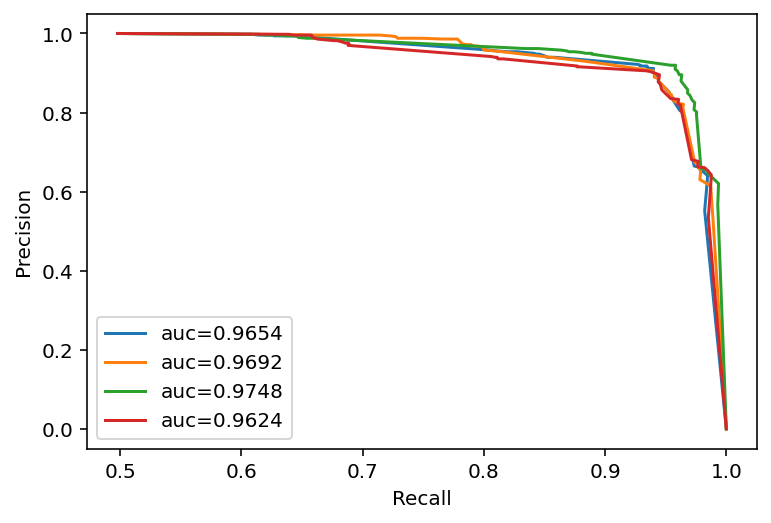

In [26]:
plt.plot(figsize=(12, 8))
#plt.title(f"Stability $\epsilon$={gamma:.2f}")
for i, [p, r, aucs] in res.items():
    plt.plot(p, r, label=f"auc={aucs:.4f}")

plt.legend();
plt.xlabel('Recall')
plt.ylabel('Precision');
plt.savefig('../fig/stab.svg', format='svg', bbox_inches = 'tight', dpi=1000)

## Efficient gammas
For both merged and streamed networks

In [5]:
with open('../res/stream-th15_merged.pickle', 'rb') as f:
    st_m = pickle.load(f)

In [66]:
apks.shape[0]

10003

In [15]:
apks = mw['apk'].unique()

In [14]:
k = 10e4
sim_recom = tc.item_similarity_recommender.create(mw, 
                                                      user_id='function', 
                                                      item_id='apk', 
                                                      similarity_type='jaccard', 
                                                      only_top_k=k,
                                                      degree_approximation_threshold = 15*4096,
                                                      threshold=0.0, verbose=False)

In [60]:
items =sim_recom.get_similar_items(apks, k=int(k))

items['distance'] = 1.0 - items['score']

items = items.remove_columns(column_names=['score', 'rank'])

In [57]:
def get_over_distances(net, items, gamma):
    for_gam_di = items[items['distance']>gamma].filter_by(values=list(net.keys()), column_name='apk')
    res = dict()
    for key, aggs in tqdm(net.items()):
        loc_dat = for_gam_di[for_gam_di['apk']==key].filter_by(values=aggs, column_name='similar')
        max_dst = loc_dat['distance'].max()
        if max_dst:
            row = loc_dat[loc_dat['distance']==max_dst][0]['similar']
            res[key] = [max_dst, row]
    return res

In [63]:
distances = dict()
for gamma, net in st_m.items():
    print(gamma)
    distances[gamma] = get_over_distances(net, items, gamma=gamma)
    

0.0


  0%|          | 0/1131 [00:00<?, ?it/s]

0.05555555555555555


  0%|          | 0/940 [00:00<?, ?it/s]

0.1111111111111111


  0%|          | 0/874 [00:00<?, ?it/s]

0.16666666666666666


  0%|          | 0/826 [00:00<?, ?it/s]

0.2222222222222222


  0%|          | 0/781 [00:00<?, ?it/s]

0.2777777777777778


  0%|          | 0/739 [00:00<?, ?it/s]

0.3333333333333333


  0%|          | 0/685 [00:00<?, ?it/s]

0.3888888888888889


  0%|          | 0/642 [00:00<?, ?it/s]

0.4444444444444444


  0%|          | 0/592 [00:00<?, ?it/s]

0.5


  0%|          | 0/536 [00:00<?, ?it/s]

0.5555555555555556


  0%|          | 0/492 [00:00<?, ?it/s]

0.6111111111111112


  0%|          | 0/424 [00:00<?, ?it/s]

0.6666666666666666


  0%|          | 0/375 [00:00<?, ?it/s]

0.7222222222222222


  0%|          | 0/320 [00:00<?, ?it/s]

0.7777777777777778


  0%|          | 0/262 [00:00<?, ?it/s]

0.8333333333333334


  0%|          | 0/203 [00:00<?, ?it/s]

0.8888888888888888


  0%|          | 0/150 [00:00<?, ?it/s]

0.9444444444444444


  0%|          | 0/88 [00:00<?, ?it/s]

1.0


  0%|          | 0/5 [00:00<?, ?it/s]

In [59]:
for k, [md, si] in dst.items():
    if si not in net[k]:
        print(f"Attribution error {si}, {k}")

In [91]:
with open('../res/distances.stream-th15_merged.pickle', 'rb') as f:
    distances_stream = pickle.load(f)

In [75]:
s1 = set(mw[mw['apk']==20276]['function'])

s2 = set(mw[mw['apk']==16393]['function'])

In [76]:
len(s1), len(s2)

(9, 2)

In [77]:
def jaccard(p1, p2) -> float:

    return 1 - len(p1 & p2)/len(p1|p2)

In [78]:
jaccard(s1, s2)

0.7777777777777778

In [92]:
def print_max_distances(distances):
    for gamma, its in distances.items():
        if not its:
            continue
        print(gamma, sorted(its.items(), key=lambda x: x[1][0], reverse=True)[0])


In [94]:
with open('../res/distances.stream-th15_merged.pickle', 'rb') as f:
    distances_stream = pickle.load(f)
    
with open('../res/distances.merged-th15_merged.pickle', 'rb') as f:
    distances_merg = pickle.load(f)

In [93]:
print_max_distances(distances_stream)

0.0 (14982, [0.9933775067329407, 11019])
0.05555555555555555 (14982, [0.9933775067329407, 11019])
0.1111111111111111 (14982, [0.9933775067329407, 11019])
0.16666666666666666 (14982, [0.9933775067329407, 11019])
0.2222222222222222 (14982, [0.9933775067329407, 11019])
0.2777777777777778 (14982, [0.9933775067329407, 11019])
0.3333333333333333 (14982, [0.9933775067329407, 11019])
0.3888888888888889 (14982, [0.9933775067329407, 11019])
0.4444444444444444 (14982, [0.9933775067329407, 11019])
0.5 (14982, [0.9933775067329407, 11019])
0.5555555555555556 (14982, [0.9933775067329407, 11019])
0.6111111111111112 (14982, [0.9933775067329407, 11019])
0.6666666666666666 (14982, [0.9933775067329407, 11019])
0.7222222222222222 (14982, [0.9933775067329407, 11019])
0.7777777777777778 (14982, [0.9933775067329407, 11019])
0.8333333333333334 (1047, [0.9953051805496216, 3719])
0.8888888888888888 (14982, [0.9933775067329407, 11019])
0.9444444444444444 (7046, [0.9958677887916565, 11019])


In [95]:
print_max_distances(distances_merg)

0.0 (8439, [0.9999622106552124, 3])
0.05555555555555555 (8439, [0.9999622106552124, 3])
0.1111111111111111 (8439, [0.9999622106552124, 3])
0.16666666666666666 (8439, [0.9999622106552124, 3])
0.2222222222222222 (8439, [0.9999622106552124, 3])
0.2777777777777778 (21828, [0.999957263469696, 3])
0.3333333333333333 (21828, [0.999957263469696, 3])
0.3888888888888889 (21828, [0.999957263469696, 3])
0.4444444444444444 (21828, [0.999957263469696, 3])
0.5 (21828, [0.999957263469696, 3])
0.5555555555555556 (21828, [0.999957263469696, 3])
0.6111111111111112 (21828, [0.999957263469696, 3])
0.6666666666666666 (18052, [0.9999618530273438, 3])
0.7222222222222222 (1669, [0.9999619722366333, 3])
0.7777777777777778 (21828, [0.999957263469696, 3])
0.8333333333333334 (21828, [0.999957263469696, 3])
0.8888888888888888 (3, [0.9999366998672485, 735])
0.9444444444444444 (6947, [0.999950110912323, 2])


In [105]:
mw[(mw['apk']==3)]

apk,function
3,178583
3,101925


In [106]:
mw[mw['apk']==14982]

apk,function
14982,25486
14982,309242
14982,232468
14982,590276
14982,22970
14982,140523
14982,318061
14982,210426
14982,526072
14982,239167


In [107]:
import glob

In [151]:
references = dict()
#0.6111111111111112-tc-singlereferenceaggregating.pickle
for an in glob.glob('../res/*-tc-singlereferenceaggregating.pickle'):
    w =an.split('-')[0][len('../res/'):]
    gamma = float(w)
   
    with open(an, 'rb') as f:
        reference = pickle.load(f)
    print(gamma, len(reference[gamma][0]))
    references[gamma] = reference[gamma][0]

0.5 1269
1.0 9
0.2222222222222222 2084
0.1111111111111111 2448
0.7777777777777778 526
0.6666666666666666 835
0.16666666666666666 2262
0.8888888888888888 267
0.7222222222222222 686
0.9444444444444444 137
0.3888888888888889 1601
0.8333333333333334 403
0.4444444444444444 1441
0.2777777777777778 1937
0.3333333333333333 1762
0.05555555555555555 2672
0.0 3513
0.5555555555555556 1134
0.6111111111111112 980


In [152]:
with open('../res/reference-th15_merged.pickle', 'wb+') as f:
    pickle.dump(references, f)

In [20]:
aggs_dist = items[items['apk']==key].filter_by(values=aggs, column_name='similar')

In [22]:
aggs_dist['distance'] = 1.0-aggs_dist['score']

In [24]:
aggs_dist[aggs_dist['distance']>gam]

apk,similar,score,rank,distance
16393,964,0.1111111044883728,2718,0.8888888955116272
16393,11528,0.10526317358016968,2720,0.8947368264198303
16393,12223,0.08333331346511841,2772,0.9166666865348816
16393,26350,0.07692307233810425,2802,0.9230769276618958
16393,4305,0.07407408952713013,2810,0.9259259104728699
16393,595,0.05555558204650879,2897,0.9444444179534912
16393,16873,0.050000011920928955,2933,0.949999988079071


In [25]:
16873 in net[key]

True

In [153]:
with open('../res/distances.reference-th15.pickle','rb') as f:
    ref_dis = pickle.load(f)

In [154]:
# surprise surprise there are no missassigned apps in reference net
ref_dis

{0.5: {},
 1.0: {},
 0.2222222222222222: {},
 0.1111111111111111: {},
 0.7777777777777778: {},
 0.6666666666666666: {},
 0.16666666666666666: {},
 0.8888888888888888: {},
 0.7222222222222222: {},
 0.9444444444444444: {},
 0.3888888888888889: {},
 0.8333333333333334: {},
 0.4444444444444444: {},
 0.2777777777777778: {},
 0.3333333333333333: {},
 0.05555555555555555: {},
 0.0: {},
 0.5555555555555556: {},
 0.6111111111111112: {}}

In [64]:
! ls -altr ../res/distances*

-rw-r--r--  1 jj  staff   57079 Feb 12 12:34 ../res/distances-defaulttr.csv
-rw-r--r--  1 jj  staff   72706 Feb 12 12:34 ../res/distances-multiplethre.csv
-rw-r--r--  1 jj  staff   71776 Feb 12 12:34 ../res/distances-2trh.csv
-rw-r--r--  1 jj  staff  120303 Feb 25 13:24 ../res/distances.stream-th15_merged.pickle
-rw-r--r--  1 jj  staff  448248 Feb 26 09:19 ../res/distances.merged-th15_merged.pickle
-rw-r--r--  1 jj  staff     225 Mar  2 12:58 ../res/distances.reference-th15.pickle
-rw-r--r--  1 jj  staff     225 Mar 11 10:16 ../res/distances.new_merged-th15.pickle
-rw-r--r--  1 jj  staff     225 Mar 11 12:31 ../res/distances.new2_merged.pickle
-rw-r--r--  1 jj  staff  120287 Mar 11 14:40 ../res/distances.streamed_new.pickle


In [65]:
with open('../res/distances.streamed_new.pickle','rb') as f:
    stream_dis = pickle.load(f)

with open('../res/distances.new2_merged.pickle','rb') as f:
    mer_dis = pickle.load(f)

In [71]:
mer_dis

{0.3888888888888889: {},
 0.2777777777777778: {},
 0.1111111111111111: {},
 0.8888888888888888: {},
 1.0: {},
 0.2222222222222222: {},
 0.9444444444444444: {},
 0.5555555555555556: {},
 0.3333333333333333: {},
 0.16666666666666666: {},
 0.0: {},
 0.6111111111111112: {},
 0.5: {},
 0.7777777777777778: {},
 0.8333333333333334: {},
 0.7222222222222222: {},
 0.4444444444444444: {},
 0.05555555555555555: {},
 0.6666666666666666: {}}

In [46]:
def get_distance_stats(dis):
    re_mm = dict()
    for gamma, vls in dis.items():
        dssts = [dst for _, [dst, anch] in vls.items()]
        if dssts:
            re_mm[gamma] = [max(dssts), np.mean(dssts)]

    return pd.DataFrame.from_dict(re_mm, orient='index', columns=['max', 'mean'])



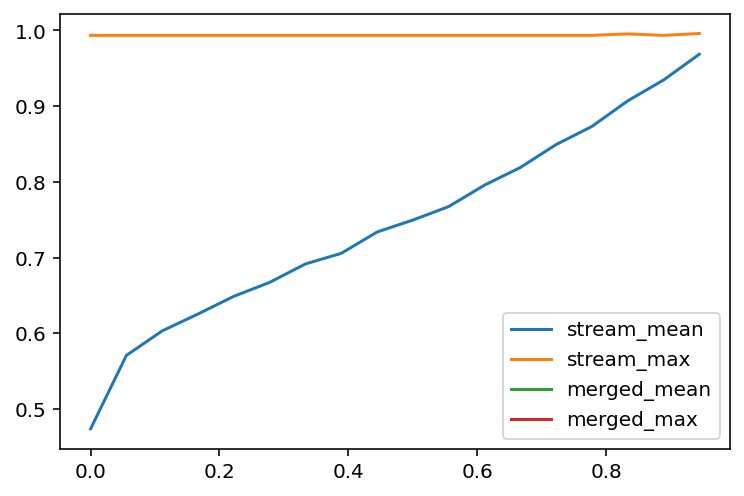

In [70]:
stream_df = get_distance_stats(stream_dis)
merg_df = get_distance_stats(mer_dis)

plt.plot(stream_df['mean'], label='stream_mean')
plt.plot(stream_df['max'], label='stream_max')
plt.plot(merg_df['mean'], label='merged_mean')
plt.plot(merg_df['max'], label='merged_max')
plt.legend();

In [4]:
mer_dis

{0.0: {24576: [0.9942432045936584, 0],
  16384: [0.9953051805496216, 0],
  4097: [0.9821428656578064, 0],
  16386: [0.9845559597015381, 0],
  3: [0.9997796416282654, 33],
  8197: [0.9845559597015381, 0],
  20485: [0.9985244870185852, 0],
  6: [0.6000000238418579, 3],
  12294: [0.9992042183876038, 0],
  20486: [0.9940119981765747, 0],
  20487: [0.9985562562942505, 0],
  11: [0.993755578994751, 0],
  4109: [0.9989763498306274, 0],
  4111: [0.9954545497894287, 0],
  12305: [0.9971932768821716, 0],
  20497: [0.9828022122383118, 0],
  24595: [0.9976862668991089, 0],
  20501: [0.9846153855323792, 0],
  16406: [0.9929714202880859, 0],
  12310: [0.9896907210350037, 0],
  12315: [0.984375, 0],
  28: [0.9685929417610168, 0],
  4124: [0.9994460344314575, 0],
  8225: [0.9942445755004883, 0],
  20513: [0.9991029500961304, 11],
  20514: [0.9985976815223694, 0],
  35: [0.9886792302131653, 0],
  20516: [0.9949832558631897, 0],
  12327: [0.9987595081329346, 2],
  20519: [0.9998641014099121, 3],
  8232:

In [61]:
net_file_name = '../res/stream-th15_merged.pickle'
print(f"Reading in nets from {net_file_name}")
with open(net_file_name, 'rb') as f:
    allthenet = pickle.load(f)


Reading in nets from ../res/stream-th15_merged.pickle


In [62]:
n0 = allthenet[0.0]

In [63]:
n0

{16393: [3,
  8200,
  16395,
  24590,
  16,
  8210,
  24594,
  8213,
  24599,
  16408,
  30,
  16417,
  16433,
  50,
  8245,
  16443,
  24645,
  24646,
  24654,
  82,
  24661,
  86,
  91,
  16479,
  24674,
  16484,
  124,
  24700,
  127,
  24707,
  132,
  24708,
  152,
  154,
  155,
  16540,
  158,
  24737,
  168,
  24746,
  174,
  24752,
  24753,
  24755,
  24763,
  189,
  24768,
  24770,
  16579,
  202,
  16587,
  215,
  24799,
  24809,
  16618,
  237,
  16626,
  244,
  245,
  24820,
  24831,
  24834,
  24836,
  24842,
  24843,
  8468,
  16663,
  16665,
  16680,
  16683,
  16686,
  24879,
  8498,
  8501,
  311,
  24888,
  24895,
  319,
  336,
  24912,
  342,
  16732,
  16733,
  8542,
  16737,
  24931,
  24933,
  16741,
  16742,
  360,
  24937,
  16746,
  8551,
  16744,
  8555,
  24942,
  367,
  16752,
  24946,
  24947,
  24948,
  16757,
  376,
  8569,
  8573,
  8581,
  8583,
  396,
  24975,
  16786,
  16793,
  16798,
  8607,
  24994,
  16803,
  8615,
  425,
  435,
  437,
  440,
  250

In [19]:
import glob

merged = dict()
#0.6111111111111112-tc-singlereferenceaggregating.pickle
for an in glob.glob('../res/*-tc-singleaggregating.pickle'):
    w =an.split('-')[0][len('../res/'):]
    gamma = float(w)
   
    with open(an, 'rb') as f:
        net = pickle.load(f)
    print(gamma, len(net[gamma][0]))
    merged[gamma] = net[gamma][0]

0.3888888888888889 642
0.2777777777777778 739
0.1111111111111111 874
0.8888888888888888 150
1.0 5
0.2222222222222222 781
0.9444444444444444 88
0.5555555555555556 492
0.3333333333333333 685
0.16666666666666666 826
0.0 1131
0.6111111111111112 424
0.5 536
0.7777777777777778 262
0.8333333333333334 203
0.7222222222222222 320
0.4444444444444444 592
0.05555555555555555 940
0.6666666666666666 375


In [22]:
with open('../res/merged-th15_agg.pickle', 'wb+') as f:
    pickle.dump(merged, f)

In [72]:
net_file_name = '../res/stream-th15_merged.pickle' #'../res/distances.new2_merged.pickle'
print(f"Reading in nets from {net_file_name}")
with open(net_file_name, 'rb') as f:
    allthenet = pickle.load(f)

Reading in nets from ../res/stream-th15_merged.pickle


In [73]:
allthenet[0.0]

{16393: [3,
  8200,
  16395,
  24590,
  16,
  8210,
  24594,
  8213,
  24599,
  16408,
  30,
  16417,
  16433,
  50,
  8245,
  16443,
  24645,
  24646,
  24654,
  82,
  24661,
  86,
  91,
  16479,
  24674,
  16484,
  124,
  24700,
  127,
  24707,
  132,
  24708,
  152,
  154,
  155,
  16540,
  158,
  24737,
  168,
  24746,
  174,
  24752,
  24753,
  24755,
  24763,
  189,
  24768,
  24770,
  16579,
  202,
  16587,
  215,
  24799,
  24809,
  16618,
  237,
  16626,
  244,
  245,
  24820,
  24831,
  24834,
  24836,
  24842,
  24843,
  8468,
  16663,
  16665,
  16680,
  16683,
  16686,
  24879,
  8498,
  8501,
  311,
  24888,
  24895,
  319,
  336,
  24912,
  342,
  16732,
  16733,
  8542,
  16737,
  24931,
  24933,
  16741,
  16742,
  360,
  24937,
  16746,
  8551,
  16744,
  8555,
  24942,
  367,
  16752,
  24946,
  24947,
  24948,
  16757,
  376,
  8569,
  8573,
  8581,
  8583,
  396,
  24975,
  16786,
  16793,
  16798,
  8607,
  24994,
  16803,
  8615,
  425,
  435,
  437,
  440,
  250

In [75]:
n = allthenet[0.5]

In [94]:
from effradius import setup_items, get_over_distances

In [88]:
def setup_items(data):
    print('Setting up items')
    apks = data['apk'].unique()
    k = apks.shape[0]
    sim_recom = tc.item_similarity_recommender.create(data, 
                                                      user_id='function', 
                                                      item_id='apk', 
                                                      similarity_type='jaccard', 
                                                      only_top_k=k,
                                                      degree_approximation_threshold = 15*4096,
                                                      threshold=0.0, verbose=False)
    items =sim_recom.get_similar_items(apks, k=int(k))

    items['distance'] = 1.0 - items['score']

    items = items.remove_columns(column_names=['score', 'rank'])
    return items

In [89]:
items = setup_items(data=mw)

Setting up items


In [76]:
dsts = get_over_distances(net=n, items=items, gamma=0.5)

100%|██████████| 536/536 [03:42<00:00,  2.41it/s]


In [79]:
## new efficient radius

In [37]:
import glob 

def concat_nets(prefix='../res/', wildcard='*-tc-singlereferenceaggregating.pickle'):
    nets = dict()
    for an in glob.glob(wildcard):
        w =an.split('-')[0][len(prefix):]
        gamma = float(w)

        with open(an, 'rb') as f:
            n = pickle.load(f)
        print(gamma, len(n[gamma][0]))
        nets[gamma] = n[gamma][0]
    return nets

In [92]:
with open('../res/distances.streamed_new.pickle','rb') as f:
    stream_dis = pickle.load(f)

with open('../res/distances-newmer.pickle','rb') as f:
    mer_dis = pickle.load(f)

In [50]:
with open('../res/newres/newstream-distances.pickle','rb') as f:
    stream_dis = pickle.load(f)

with open('../res/newres/newmerg-distances.pickle','rb') as f:
    mer_dis = pickle.load(f)

In [51]:
stream_df = get_distance_stats(stream_dis)
merg_df = get_distance_stats(mer_dis)
merg_df.sort_index(inplace=True)


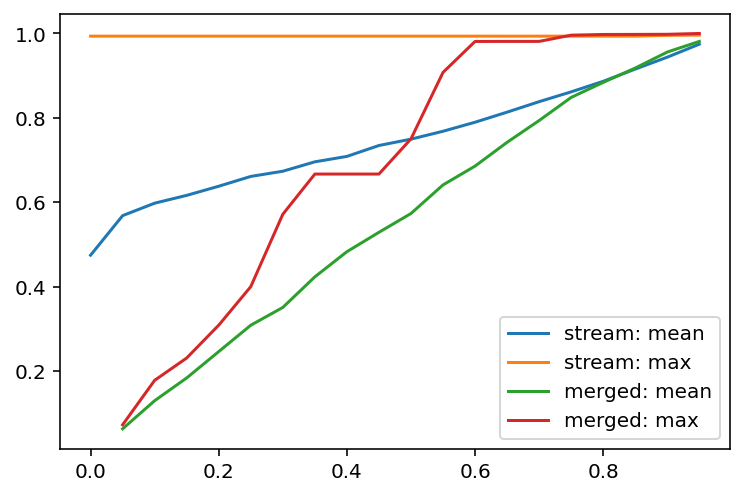

In [53]:
#plt.title('Effective $\epsilon$')
plt.plot(stream_df['mean'], label='stream: mean')
plt.plot(stream_df['max'], label='stream: max')
plt.plot(merg_df['mean'], label='merged: mean')
plt.plot(merg_df['max'], label='merged: max')
plt.legend();

plt.savefig('../fig/eff.svg', format='svg', bbox_inches = 'tight', dpi=1000)

In [138]:
# verify streamed

In [99]:
stream_dis

{0.0: {16393: [0.7777777910232544, 20276],
  10246: [0.1228373646736145, 13144],
  18442: [0.6722898483276367, 13095],
  4109: [0.6121947169303894, 8034],
  18448: [0.004269421100616455, 19997],
  4115: [0.8181818127632141, 11976],
  26649: [0.4148319959640503, 26142],
  2077: [0.005237996578216553, 3405],
  2094: [0.5860679149627686, 1374],
  2098: [0.07671231031417847, 5940],
  18484: [0.9732815027236938, 10348],
  18490: [0.4166666865348816, 5214],
  18494: [0.6617109179496765, 2458],
  16466: [0.5695331692695618, 16030],
  26713: [0.8395061492919922, 13184],
  6233: [0.0017271041870117188, 17976],
  24666: [0.36111539602279663, 8223],
  16478: [0.028248608112335205, 26815],
  4190: [0.19999998807907104, 16678],
  24673: [0.8602316379547119, 3788],
  4199: [0.1666666865348816, 438],
  20591: [0.7080726623535156, 20558],
  14448: [0.0018867850303649902, 24951],
  4209: [0.6150859594345093, 19103],
  26742: [0.5703417062759399, 24949],
  6265: [0.0022800564765930176, 18608],
  24699: 

In [90]:
net_file_name = '../res/stream-th15_merged.pickle' #'../res/distances.new2_merged.pickle'
print(f"Reading in nets from {net_file_name}")
with open(net_file_name, 'rb') as f:
    allthenet = pickle.load(f)

Reading in nets from ../res/stream-th15_merged.pickle


In [100]:
gamma = 0.5
dsts = stream_dis[gamma]
net = allthenet[gamma]

In [101]:
a = list(net.keys())
b = list(dsts.keys())

len(a), len(b)

(536, 336)

In [172]:
m = pd.read_csv('../data/joined.csv', index_col='apn')
m['nf'] = m['nf'].apply(eval)
def jaccard(apid1: int, apid2: int, funcs) -> float:
    p1 = funcs[apid1]
    p2 = funcs[apid2]

    return 1 - len(p1 & p2)/len(p1|p2)

# good old panda based distance calculation:
distance = lambda x,y: jaccard(x, y, m['nf'])

In [180]:
#1. verify that the outlier are really in net (perhaps check the distance?)
err = 0
for an, [dist, b] in dsts.items():
    if an not in net.keys():
        print('Wrong key!')
    if b not in net[an]:
        print('Wrong anchor!')
    g=distance(an, b)
    err = max(err, abs(g-dist))
    
print(f"max distance erro {err}")

max distance erro 2.975516122383226e-08


In [187]:
#2. verify the non-existing keys
di = [m for m in net.keys() if m not in dsts.keys()]

for an in di:
    agg = net[an]
    if not agg:
        continue
    max_dist = max([distance(a, an) for a in agg])
    if max_dist>gamma:
        print(an, max_dist)
        

In [190]:
for gamma, net in allthenet.items():
    outliners = list()
    for an, agg in net.items():
        if not agg:
            continue
        max_dist = max([distance(a, an) for a in agg])
        if max_dist>gamma:
            outliners.append(max_dist)

    print(gamma, max(outliners))

0.0 0.9933774834437086
0.05555555555555555 0.9933774834437086
0.1111111111111111 0.9933774834437086
0.16666666666666666 0.9933774834437086
0.2222222222222222 0.9933774834437086
0.2777777777777778 0.9933774834437086
0.3333333333333333 0.9933774834437086
0.3888888888888889 0.9933774834437086
0.4444444444444444 0.9933774834437086
0.5 0.9933774834437086
0.5555555555555556 0.9933774834437086
0.6111111111111112 0.9933774834437086
0.6666666666666666 0.9933774834437086
0.7222222222222222 0.9933774834437086
0.7777777777777778 0.9933774834437086
0.8333333333333334 0.9953051643192489
0.8888888888888888 0.9933774834437086
0.9444444444444444 0.9958677685950413


ValueError: max() arg is an empty sequence

In [211]:
for gamma, ad in stream_dis.items():
    if any(ad):
        print(gamma, max(ad.values(), key=lambda x: x[0]))

0.0 [0.9933775067329407, 11019]
0.05555555555555555 [0.9933775067329407, 11019]
0.1111111111111111 [0.9933775067329407, 11019]
0.16666666666666666 [0.9933775067329407, 11019]
0.2222222222222222 [0.9933775067329407, 11019]
0.2777777777777778 [0.9933775067329407, 11019]
0.3333333333333333 [0.9933775067329407, 11019]
0.3888888888888889 [0.9933775067329407, 11019]
0.4444444444444444 [0.9933775067329407, 11019]
0.5 [0.9933775067329407, 11019]
0.5555555555555556 [0.9933775067329407, 11019]
0.6111111111111112 [0.9933775067329407, 11019]
0.6666666666666666 [0.9933775067329407, 11019]
0.7222222222222222 [0.9933775067329407, 11019]
0.7777777777777778 [0.9933775067329407, 11019]
0.8333333333333334 [0.9953051805496216, 3719]
0.8888888888888888 [0.9933775067329407, 11019]
0.9444444444444444 [0.9958677887916565, 11019]


In [213]:
mw[mw['apk']==11019]

apk,function
11019,104769
11019,344854


In [223]:
res = mw[(mw['function']==104769) | (mw['function']==344854)]
res.materialize()
11019 in res['apk'].unique()

True

In [89]:
res.shape()

AttributeError: 'dict' object has no attribute 'shape'

In [ ]:
histogram of minimal distance to the anchors, 
number of misalligned apps
check if this is malicious
90% of others

In [103]:
# get misalligned apps

In [136]:
#res = dict()



def get_outliers(net, gamma):
    outl = list()
    for an, agg in net.items():
        if not agg:
            continue
        th = [(an, a, distance(a, an)) for a in agg]# if distance(a, an)> gamma]
        outl = outl + th
    return outl



  0%|          | 0/19 [00:00<?, ?it/s]

In [147]:
res = dict()
for gamma, net in tqdm(allthenet.items()):
    res[gamma] = get_outliers(net, gamma)

  0%|          | 0/19 [00:00<?, ?it/s]

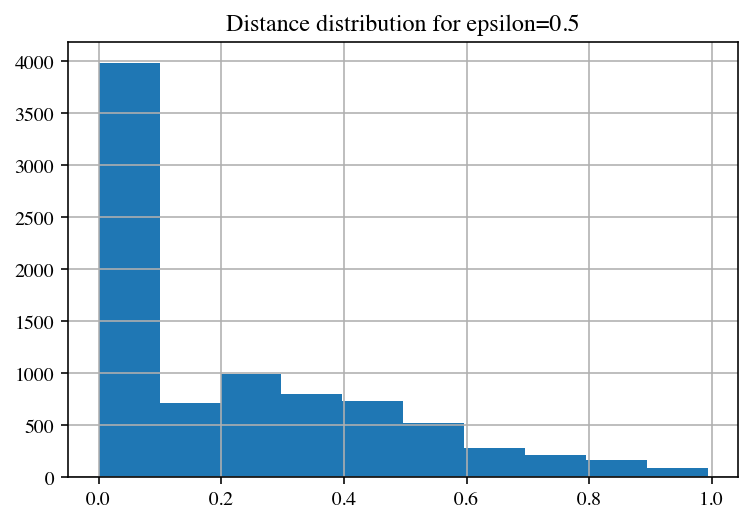

In [148]:
gamma = 0.5

df = pd.DataFrame(res[gamma], columns=['anchor', 'apk', 'distance'])

df.distance.hist(bins=10 )
plt.title(f"Distance distribution for epsilon={gamma}");

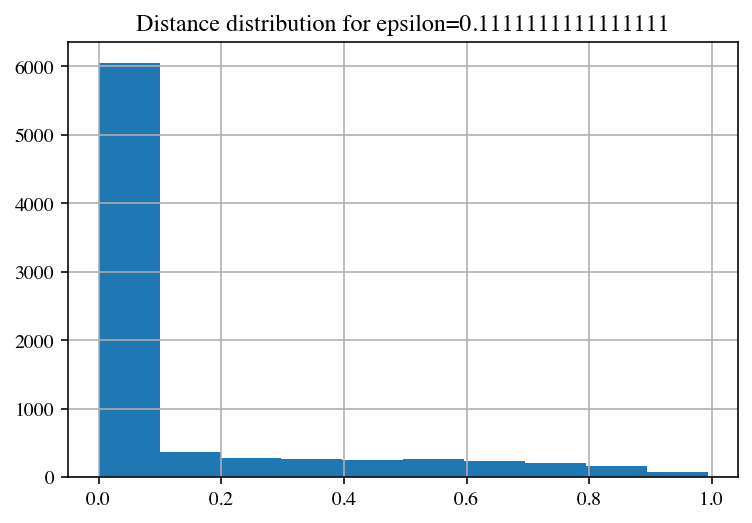

In [150]:
gamma = 0.1111111111111111

df = pd.DataFrame(res[gamma], columns=['anchor', 'apk', 'distance'])

df.distance.hist(bins=10 )
plt.title(f"Distance distribution for epsilon={gamma}");

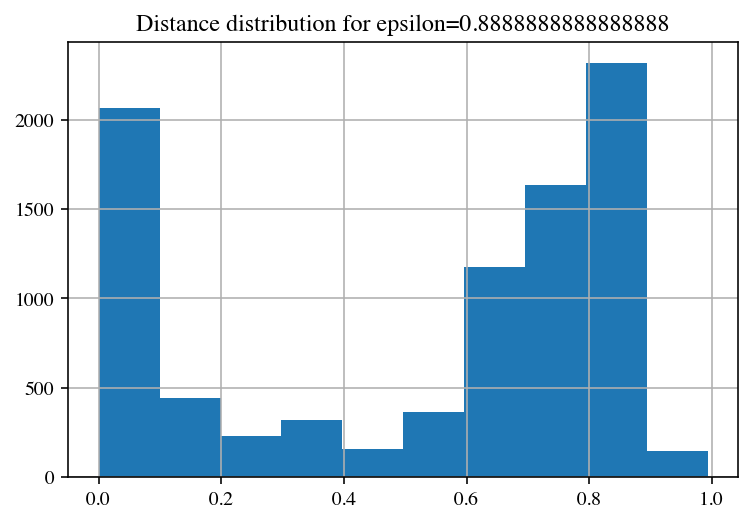

In [151]:
gamma = 0.8888888888888888
df = pd.DataFrame(res[gamma], columns=['anchor', 'apk', 'distance'])

df.distance.hist(bins=10 )
plt.title(f"Distance distribution for epsilon={gamma}");

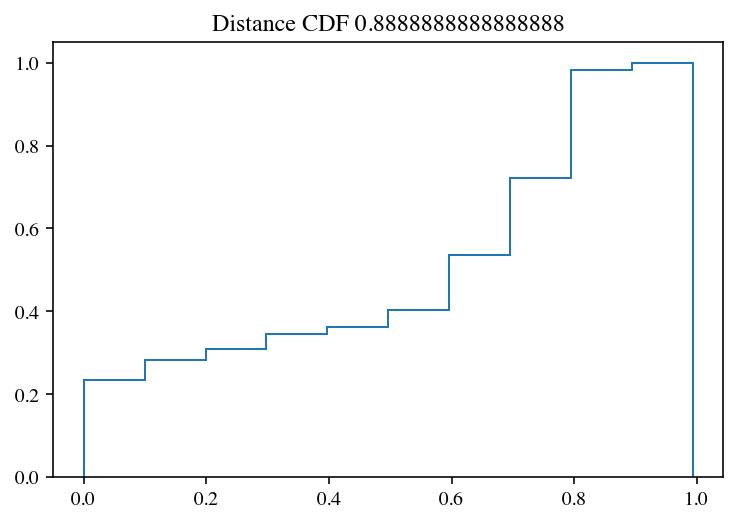

In [162]:
df = pd.DataFrame(res[gamma], columns=['anchor', 'apk', 'distance'])
plt.hist(df['distance'],bins=10, density=True, cumulative=True, histtype='step');
plt.title(f"Distance CDF {gamma}");

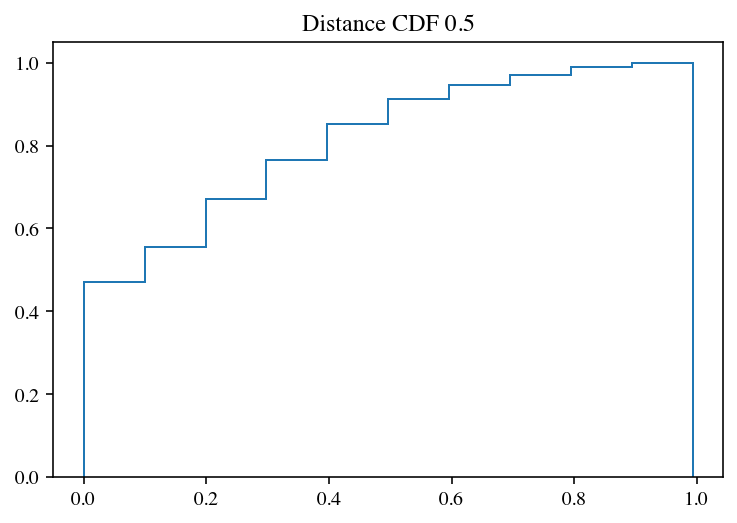

In [163]:
gamma = 0.5
df = pd.DataFrame(res[gamma], columns=['anchor', 'apk', 'distance'])
plt.hist(df['distance'],bins=10, density=True, cumulative=True, histtype='step');
plt.title(f"Distance CDF {gamma}");

In [164]:
# streamed network preserves the origin anchors, is the network correct? 
# if not why not?

In [173]:
gamma = 0.5
anet = allthenet[gamma]
dsts = res[gamma]

for (an, apk, d) in tqdm(dsts):
    dia = [distance(apk, b) for b in anet.keys() if (distance(apk, b)<d) & (b!=an)]
    if dia:
        print(an, apk, dia)

  0%|          | 0/8467 [00:00<?, ?it/s]

16393 26000 [0.4285714285714286, 0.4]
16393 18788 [0.19999999999999996]
4109 15619 [0.45201041732833636, 0.41996204933586334, 0.4526655422746938]
4109 11942 [0.3254882930971733, 0.4603506222181851]
4109 8364 [0.32863564572955895]
4109 9911 [0.46796589524969545, 0.3883169203222918]
4109 7868 [0.36926082709215236]
4109 5585 [0.46233917372470423, 0.3696002578981302]
4109 18533 [0.4173242153252674]
4109 12020 [0.32483302975106254, 0.46135682499318864]
12305 10763 [0.39181351773366047]
12305 21005 [0.3918615107913669]
12305 23103 [0.3068547768747125]
12305 17476 [0.2836288659793814]
12305 21576 [0.2836288659793814]
12305 11358 [0.2836288659793814]
12305 4209 [0.2836288659793814]
12305 17569 [0.2836288659793814]
12305 206 [0.36717012059477816]
12305 24272 [0.30435117443203696]
12305 5840 [0.3068547768747125]
12305 11487 [0.4472451483381664, 0.4478330658105939]
12305 4326 [0.33223558244619744]
12305 8940 [0.4178132549101985, 0.404662861565251]
12305 6412 [0.2836288659793814]
12305 18736 [0.31

KeyboardInterrupt: 